# Task 2

## Import Libraries

In [4]:
import sys
sys.path.append('../src')

import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
from tqdm import tqdm
from datetime import datetime

from environment_gym import TrafficEnvironment
from task2_environment import CustomTrafficEnvironment
from task2_agents import RuleBasedAgent, TemporalDifference
from visualization import extract_timesteps_from_json, create_visualization_from_cached_data

seed = 2024
training_seed = 42

## Rule-Based Agent

### Fastest Adjacent Lane

100%|██████████| 500/500 [00:31<00:00, 15.95it/s]


Truncated episodes: 153
Average cumulative rewards for Fastest Adjacent Lane strategy: -611
Average timesteps to termination for Fastest Adjacent Lane strategy: 352


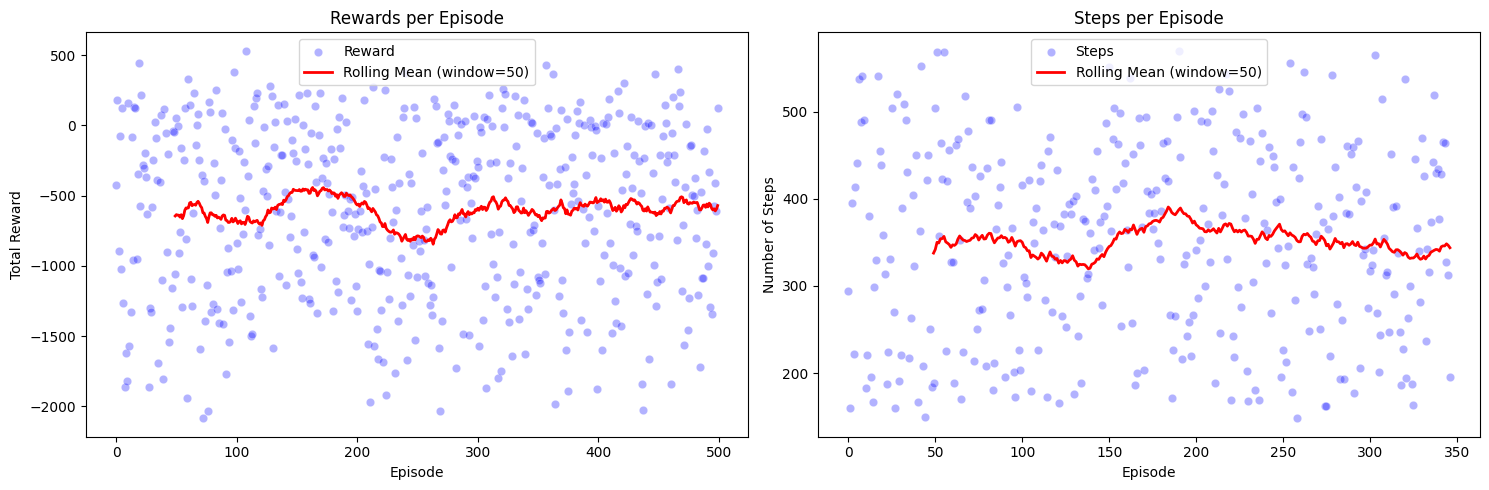

In [3]:
# Create the environment
env = CustomTrafficEnvironment(max_time_steps=10000, logging_enabled=False, seed=seed)
# Evaluate each strategy
rewards_dict = {}
timesteps_dict = {}

agent = RuleBasedAgent(env=env, strategy='fastest_adjacent')
# episode_rewards, checkpoint_rewards, timesteps_to_termination = evaluate_agent(agent, env)
all_episode_rewards, all_timesteps, fast_log_file = agent.evaluate_agent(num_episodes=500, output_file=f'./logs/task2/fast_lane/fast_lane_test_log_{datetime.now().strftime('%Y%m%d_%H%M%S')}.json')
rewards_dict['Fastest Adjacent Lane Agent'] = all_episode_rewards
timesteps_dict['Fastest Adjacent Lane Agent'] = all_timesteps
# env.logger.info("\n"*5)

print(f'Average cumulative rewards for Fastest Adjacent Lane strategy: {round(np.mean(rewards_dict['Fastest Adjacent Lane Agent']))}')
print(f'Average timesteps to termination for Fastest Adjacent Lane strategy: {round(np.mean(timesteps_dict["Fastest Adjacent Lane Agent"]))}')
agent.plot_metrics(all_episode_rewards, all_timesteps, window_size=50)
plt.show()

In [3]:
json_path = fast_log_file

extract_timesteps_from_json(json_path)
gif_filename = os.path.basename(json_path).replace('.json', '.gif')

gif_filepath = f'./gifs/task2/{gif_filename}'

create_visualization_from_cached_data(gif_filename=gif_filepath, step_interval=1)

Timesteps data from the first line successfully cached, containing 294 timesteps
GIF saved at ./gifs/task2/rule_test_log_20241106_160517.gif


### Same Lane

100%|██████████| 500/500 [00:38<00:00, 12.94it/s]

Truncated episodes: 188
Average cumulative rewards for Same Lane Agent 1: -841
Average timesteps to termination for Same Lane Agent 1: 465




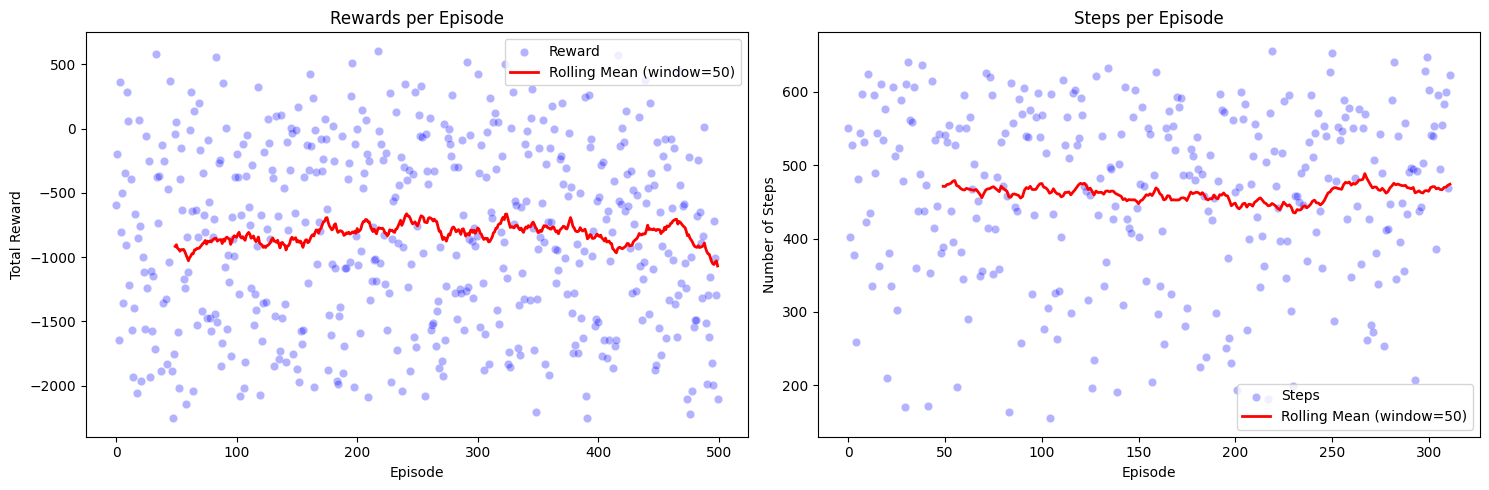

100%|██████████| 500/500 [00:38<00:00, 12.84it/s]


Truncated episodes: 185
Average cumulative rewards for Same Lane Agent 2: -728
Average timesteps to termination for Same Lane Agent 2: 471




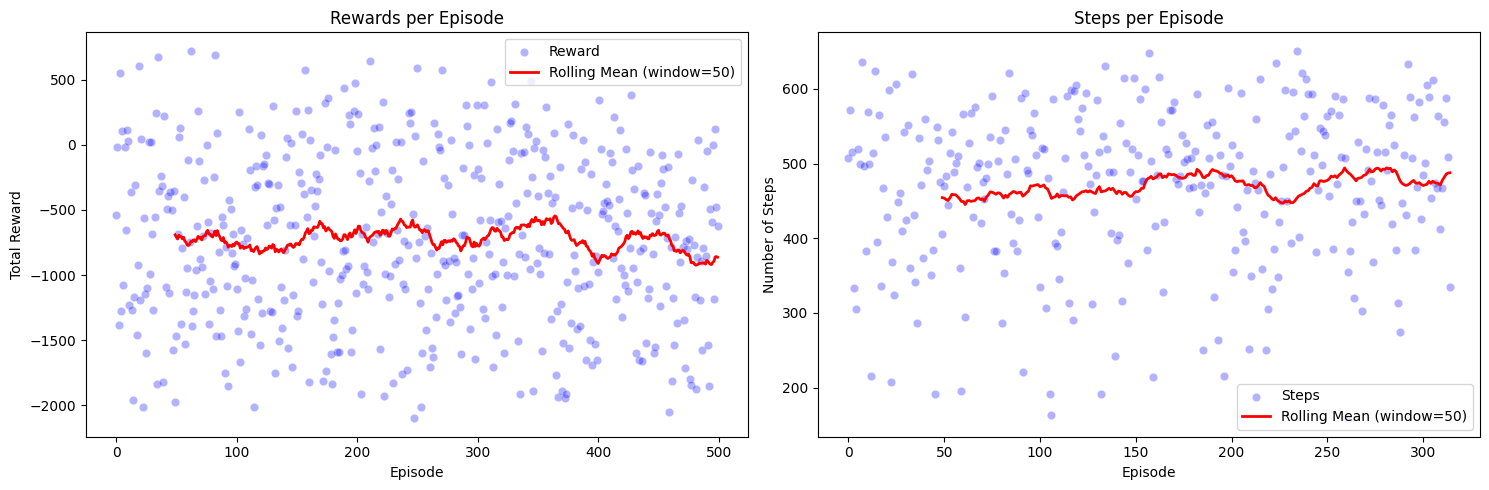

100%|██████████| 500/500 [00:38<00:00, 12.92it/s]


Truncated episodes: 178
Average cumulative rewards for Same Lane Agent 3: -701
Average timesteps to termination for Same Lane Agent 3: 452




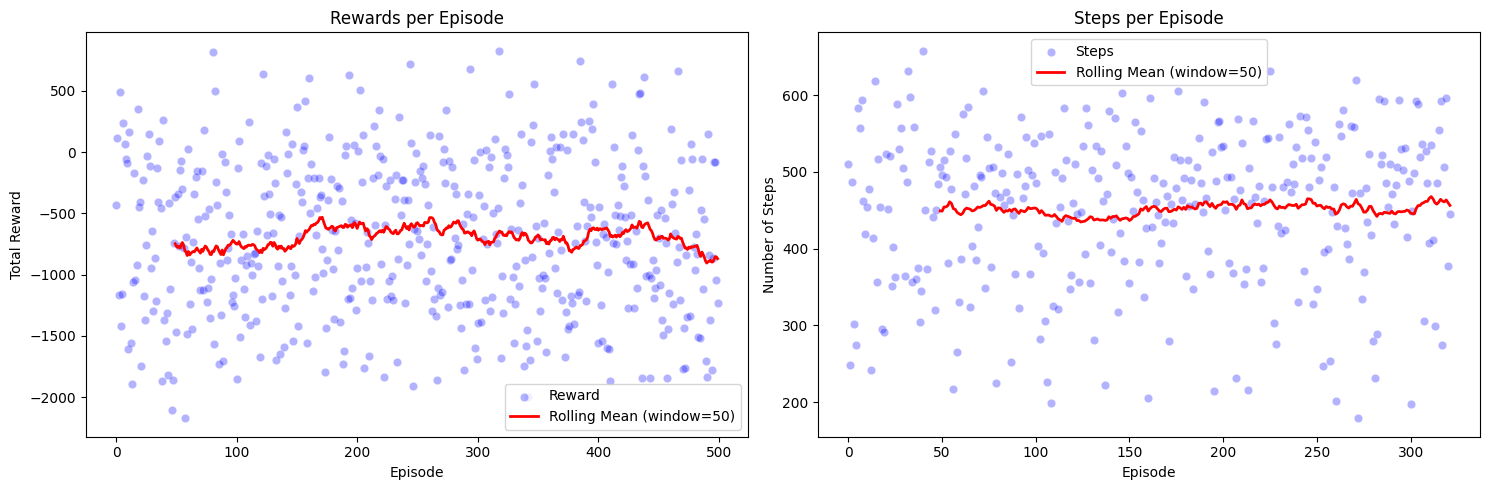

100%|██████████| 500/500 [00:41<00:00, 12.15it/s]


Truncated episodes: 186
Average cumulative rewards for Same Lane Agent 4: -748
Average timesteps to termination for Same Lane Agent 4: 473




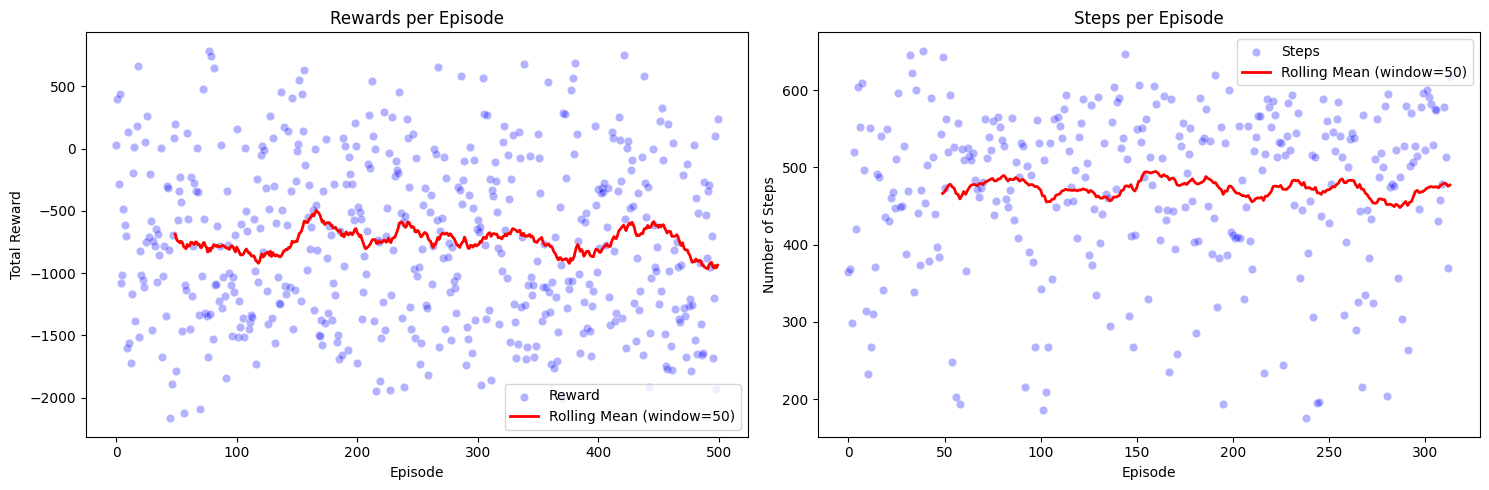

100%|██████████| 500/500 [00:41<00:00, 12.16it/s]


Truncated episodes: 185
Average cumulative rewards for Same Lane Agent 5: -958
Average timesteps to termination for Same Lane Agent 5: 481




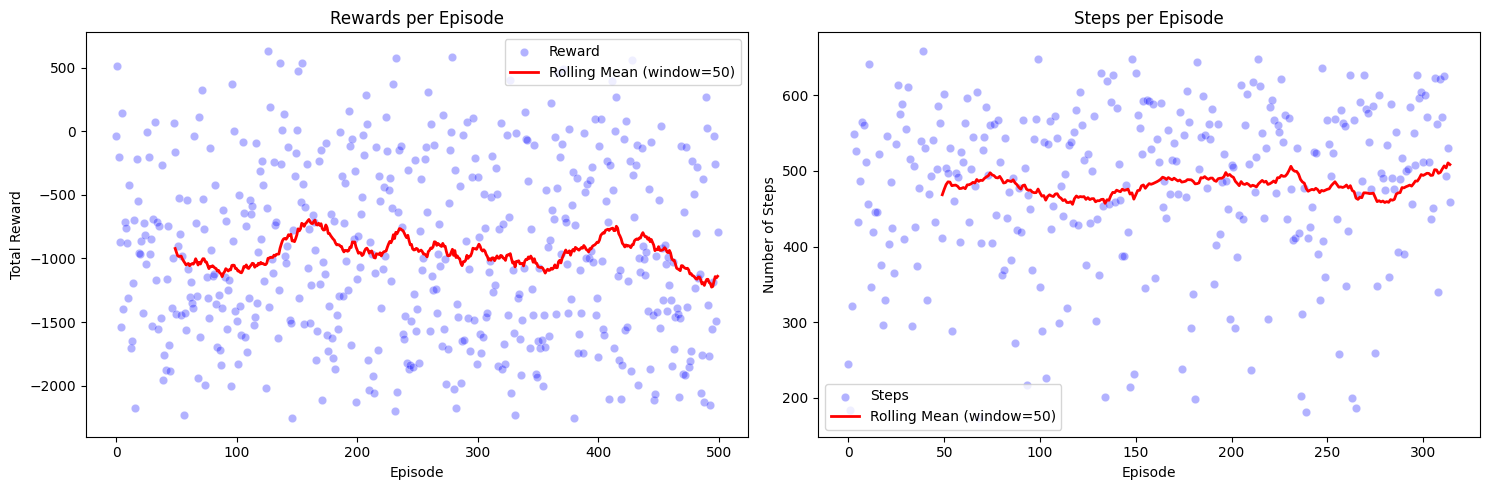

In [4]:
# Create the environment
env = CustomTrafficEnvironment(max_time_steps=10000, logging_enabled=False, seed=seed)
rewards_dict = {}
timesteps_dict = {}
log_files = []
for i in range(5):
    env.logger.info(f"Evaluating Agent {i+1}")
    agent = RuleBasedAgent(env=env, strategy='stay')
    all_episode_rewards, all_timesteps, log_file = agent.evaluate_agent(num_episodes=500, starting_lane=i+1, output_file=f'./logs/task2/same_lane/rule_lane{i+1}_test_log_{datetime.now().strftime('%Y%m%d_%H%M%S')}.json')
    log_files.append(log_file)
    rewards_dict[f'Same Lane Agent {i+1}'] = all_episode_rewards
    timesteps_dict[f'Same Lane Agent {i+1}'] = all_timesteps
    
    print(f'Average cumulative rewards for Same Lane Agent {i+1}: {round(np.mean(all_episode_rewards))}')
    print(f'Average timesteps to termination for Same Lane Agent {i+1}: {round(np.mean(all_timesteps))}')
    print('\n')
    agent.plot_metrics(all_episode_rewards, all_timesteps, window_size=50)
    plt.show()

In [12]:
for i in range(1):
    json_path = log_files[i]

    extract_timesteps_from_json(json_path)
    gif_filename = os.path.basename(json_path).replace('.json', '.gif')

    gif_filepath = f'./gifs/task2/{gif_filename}'

    create_visualization_from_cached_data(gif_filename=gif_filepath, step_interval=1)

Timesteps data from the first line successfully cached, containing 245 timesteps
GIF saved at ./gifs/task2/rule_test_log_20241106_160517.gif


## Value-based Agent

### Training

{'alpha': 0.00192124204435242, 'gamma': 0.2797587807241957, 'epsilon_min': 0.021845516948892266, 'lambd': 0.49017176264381024}

100%|██████████| 2000/2000 [02:41<00:00, 12.37it/s]


Early Termination Count: 732
Sum of total rewards = -1638174.7999999998
Average total reward per episode = -819.0874
Average steps per episode = 448.8194006309148


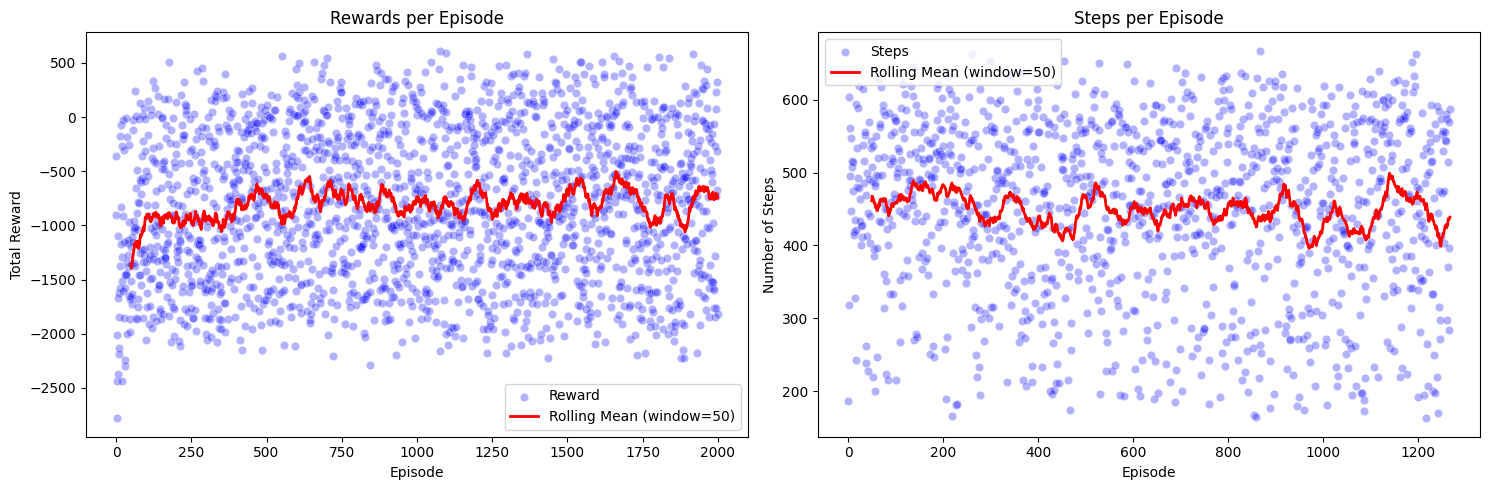

In [5]:
# Create the environment
env = CustomTrafficEnvironment(max_time_steps=10000, logging_enabled=False, seed=training_seed)

td_lambda = TemporalDifference(env, oiv = 0.1, alpha=1.92e-3, epsilon=1.0, lambd=0, gamma=0.28, epsilon_decay=0.9999, epsilon_min=0.022)
total_reward_list, total_steps_list = td_lambda.train(num_episodes = 2000, on_policy = False, save_model = False)
total_rew = sum(total_reward_list)
avg_rew = np.mean(total_reward_list)
avg_steps = np.mean(total_steps_list)

print(f'Sum of total rewards = {total_rew}')
print(f'Average total reward per episode = {avg_rew}')
print(f'Average steps per episode = {avg_steps}')

# plot training metrics
td_lambda.plot_metrics(total_reward_list, total_steps_list, window_size=50)
plt.show()

### Analysis

In [13]:
print(f'Filled State Space: {len(td_lambda.Q)}')
td_lambda.Q.items()

Filled State Space: 4401


dict_items([((5, 0, 5, 0), array([-0.07861442,  3.64430111,  0.21337632])), ((5, 5, 4, 0), array([0.10370176, 0.85865552, 0.10405185])), ((4, 5, 4, 0), array([0.28581441, 0.1       , 0.10293596])), ((4, 4, 4, 1), array([0.1028304 , 0.46245855, 0.1       ])), ((4, 4, 5, 0), array([0.11164283, 0.10896355, 0.58506957])), ((4, 4, 6, 1), array([0.10364166, 0.1       , 0.21316528])), ((6, 4, 0, 1), array([0.14788172, 0.1       , 0.09525905])), ((6, 5, 0, 1), array([0.10572176, 0.37733978, 0.1       ])), ((4, 5, 6, 2), array([0.10659462, 0.1       , 0.15038684])), ((4, 5, 5, 2), array([0.10235776, 0.35320412, 0.09549315])), ((4, 5, 5, 1), array([0.16477053, 0.10490679, 0.1       ])), ((4, 6, 4, 2), array([0.15579855, 0.1       , 0.1       ])), ((6, 0, 4, 2), array([0.07948634, 0.95643203, 0.10457836])), ((5, 0, 4, 2), array([0.06540997, 0.94848691, 0.09952755])), ((5, 0, 5, 2), array([0.05847697, 1.44562647, 0.11080095])), ((6, 0, 5, 2), array([0.07055205, 1.45321335, 0.10836108])), ((6, 6, 3

Action Distribution:
Left:   973 (21.0%)
Stay:  2985 (64.4%)
Right:  676 (14.6%)


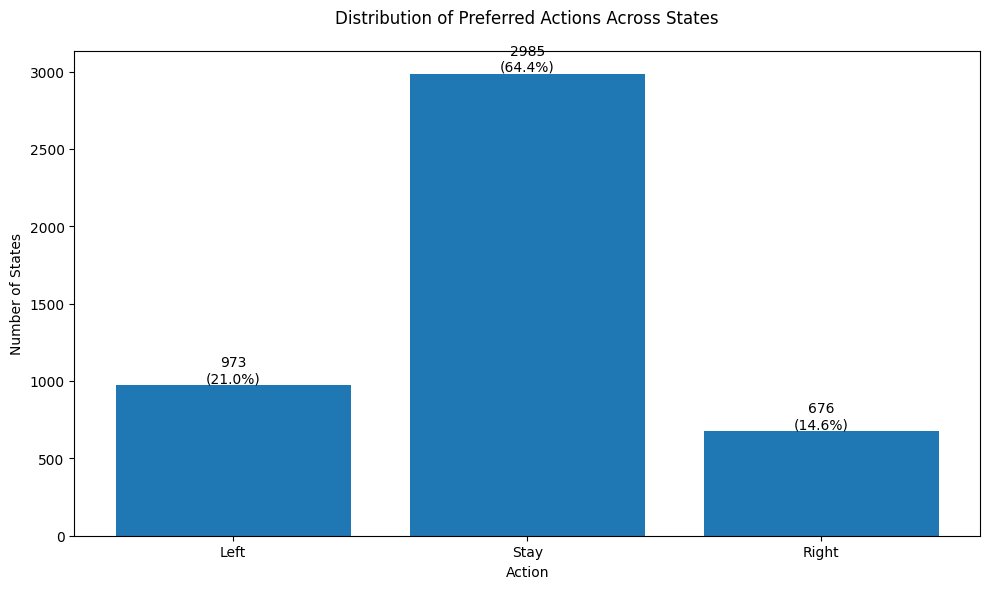

(973, 2985, 676, 20.996978851963746, 64.41519205869659, 14.587829089339662)

In [22]:
td_lambda.analyze_model_actions()

State Space Size = 10 x 10 x 10 (Clearance Rates) x 5 (Risk Factor) x 3 (Actions) = 15,000

In [4]:
q_df = td_lambda.q_table_to_dataframe()
q_df.head()

,Current Lane Rate,Left Lane Rate,Right Lane Rate,Risk Factor,Left,Stay,Right
0,5,0,5,0,-0.134044,3.600554,0.239352
1,5,5,4,0,0.103702,1.049336,0.104052
2,4,5,4,0,0.401564,0.100000,0.105422
3,4,4,4,1,0.102830,0.567883,0.100000
4,4,4,5,0,0.115135,0.124437,0.763137


In [16]:
lanes = ['Current', 'Left', 'Right']
for fast_lane in lanes:
    other_lanes = lanes.copy()
    other_lanes.remove(fast_lane)
    total = q_df.loc[((q_df[f'{fast_lane} Lane Rate'] > q_df[f'{other_lanes[0]} Lane Rate']) & (q_df[f'{fast_lane} Lane Rate'] > q_df[f'{other_lanes[1]} Lane Rate'])) & (q_df['Risk Factor'] < 5)].shape[0]
    rate = q_df.loc[((q_df[f'{fast_lane} Lane Rate'] > q_df[f'{other_lanes[0]} Lane Rate']) & (q_df[f'{fast_lane} Lane Rate'] > q_df[f'{other_lanes[1]} Lane Rate'])) & (q_df['Risk Factor'] < 5) \
    & ((q_df[f'{fast_lane if fast_lane != 'Current' else 'Stay'}'] > q_df[f'{other_lanes[0] if other_lanes[0] != 'Current' else 'Stay'}']) \
        & (q_df[f'{fast_lane if fast_lane != 'Current' else 'Stay'}'] > q_df[f'{other_lanes[1] if other_lanes[1] != 'Current' else 'Stay'}']))].shape[0]
    rate = rate/q_df.shape[0]
    print(f"Number of cases where the {fast_lane} lane is fastest and has the highest value for low risk: {rate*100}%")

NameError: name 'q_df' is not defined

### Evaluation

In [6]:
td_lambda.Env.enable_logging()

100%|██████████| 500/500 [00:41<00:00, 11.95it/s]


Early terminations: 178
Average cumulative rewards for TD-Lambda Agent: -810
Average timesteps to termination for TD-Lambda Agent: 449


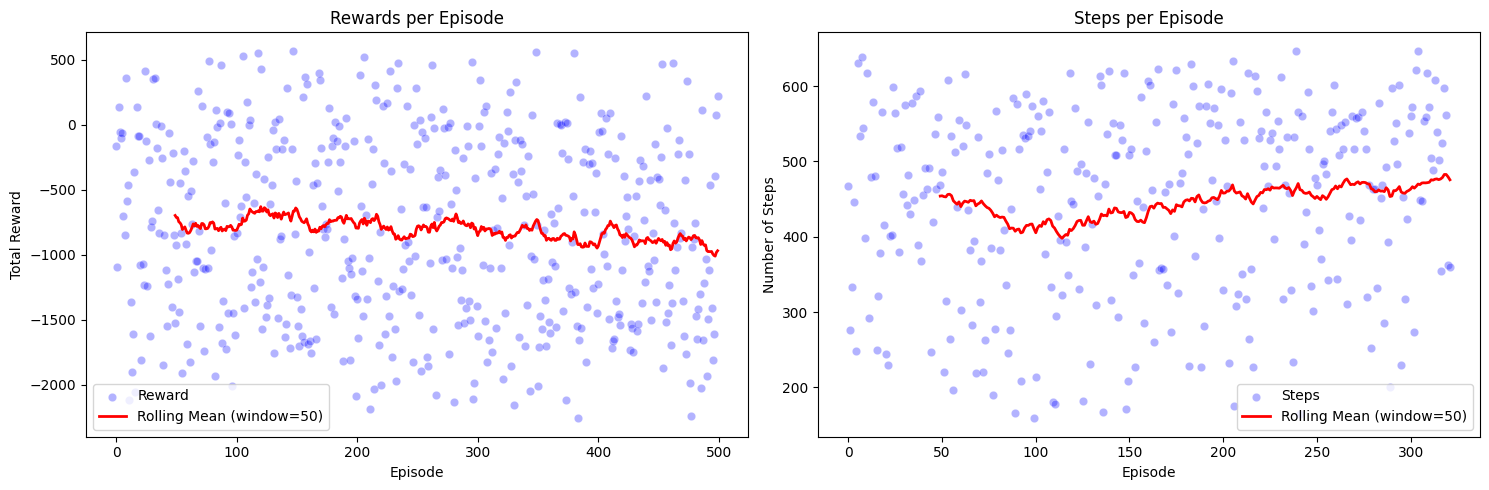

In [6]:
# Training and evaluation using different seeds
td_lambda.Env.set_seed(seed)
td_lambda.set_seed(seed)

# Evaluate the agent in inference mode
all_rewards, all_steps, log_file = td_lambda.evaluate(num_episodes=500)

# Print the results
print(f"Average cumulative rewards for TD-Lambda Agent: {round(np.mean(all_rewards))}")
print(f"Average timesteps to termination for TD-Lambda Agent: {round(np.mean(all_steps))}")

td_lambda.plot_metrics(all_rewards, all_steps, window_size=50)
plt.show()

In [7]:
td_lambda.Env.disable_logging()

### Visualization

In [6]:
json_path = log_file

extract_timesteps_from_json(json_path)
gif_filename = os.path.basename(json_path).replace('.json', '.gif')

gif_filepath = f'./gifs/task2/{gif_filename}'

create_visualization_from_cached_data(gif_filename=gif_filepath, step_interval=1)

Timesteps data from the first line successfully cached, containing 286 timesteps
GIF saved at ./gifs/task2/test_log_tdlambda_20241106_172440.gif


### Hyperparameter Tuning

In [ ]:
episodes = 1000
trials = 30
on_policy = False
hyperparameter_space = {
    'alpha': [1e-5, 1e-1],           # Learning rate range (log scale)
    'gamma': [0.1, 0.99],            # Discount factor range
    'epsilon_min': [0.01, 0.1],      # Minimum epsilon range
    # 'lambd': [0, 0.9]             # Lambda range for eligibility traces
}
env = CustomTrafficEnvironment(max_time_steps=10000, logging_enabled=False, seed=seed)
td_lambda = TemporalDifference(env)
# Run hyperparameter tuning
best_agent, best_params = td_lambda.hyperparameter_tuning(hyperparameter_space=hyperparameter_space, lambd=0, episodes=episodes, n_trials=trials, on_policy=on_policy)

[I 2024-11-06 22:02:00,428] A new study created in memory with name: no-name-8b3fde25-ec70-4423-824f-eee2c8ff690c
100%|██████████| 1000/1000 [30:02<00:00,  1.80s/it]
[I 2024-11-06 22:32:02,537] Trial 0 finished with value: -933.0018 and parameters: {'alpha': 0.0017911571512154733, 'gamma': 0.6957429528221819, 'epsilon_min': 0.07010019728072174}. Best is trial 0 with value: -933.0018.


Early Termination Count: 363
Trial 0: Average Reward = -933.00


 68%|██████▊   | 682/1000 [28:31<13:17,  2.51s/it]
[W 2024-11-06 23:00:33,563] Trial 1 failed with parameters: {'alpha': 0.00046462880844618356, 'gamma': 0.4613130802969272, 'epsilon_min': 0.06184732972271382} because of the following error: KeyboardInterrupt().
Traceback (most recent call last):
  File "c:\Users\danie\OneDrive - Singapore Management University\SMU Singapore\Academics\Aug 2024\CS609_ReinforcementLearning\Project\LaneSwitchRL-Simulation\.venv\Lib\site-packages\optuna\study\_optimize.py", line 197, in _run_trial
    value_or_values = func(trial)
                      ^^^^^^^^^^^
  File "c:\Users\danie\OneDrive - Singapore Management University\SMU Singapore\Academics\Aug 2024\CS609_ReinforcementLearning\Project\LaneSwitchRL-Simulation\notebooks\../src\task2_agents.py", line 417, in objective
    rewards, _ = self.train(num_episodes=episodes, on_policy = on_policy)
                 ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\danie\OneDrive - 

KeyboardInterrupt: 